Ba_2motifs——cin++——option2:0.01topoloss——ph_x

In [1]:
import sys
sys.path.append('./src')
import json
import torch
import torch.nn as nn
from copy import deepcopy
from pathlib import Path
from backbones import OGBEmbedCINpp
from utils import get_data_loaders, set_seed, init_metric_dict, update_and_save_best_epoch_res, ExtractorMLP, get_optimizer, load_checkpoint
from trainer import run_one_epoch, get_viz_idx, visualize_results
from datetime import datetime
from torch.nn import functional as F
from baselines import LRIBern


/home/godfrey/anaconda3/envs/topo/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using /home/godfrey/.cache/torch_extensions/py310_cu116 as PyTorch extensions root...
Emitting ninja build file /home/godfrey/.cache/torch_extensions/py310_cu116/pershom_cuda_ext/build.ninja...
Building extension module pershom_cuda_ext...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module pershom_cuda_ext...


ninja: no work to do.


In [2]:
dataset_name = 'ba_2motifs'
# dataset_name = 'mutag'
# dataset_name = 'ogbg_molhiv'
model_name = 'cinpp'

method_name = 'lri_bern'
cuda_id = 1
seed = 0
set_seed(seed)

In [3]:
data_dir = Path('../data')
device = torch.device(f'cuda:{cuda_id}' if cuda_id >= 0 else 'cpu')

model_config = {'num_layers': 3, 'emb_dim': 64, 'nonlinearity': 'relu', 'drop_rate': 0.15, 'readout': 'sum', 'final_readout':'sum', 'drop_position':'lin2',
                'graph_norm':'bn', 'atom_encoder':False}   
data_config = {'data_name': dataset_name, 'data_dir': '../data', 'max_ring_size': 5, 'include_down_adj': True, 'init_method': 'sum', 'n_jobs': 32}

method_config = {
    "one_encoder": True,
    "attn_constraint": "none",
    "temperature": 1.0,
    "decay_interval": 10,
    "decay_r": 0.1,
    "init_r": 0.9,
    "pred_loss_coef": 1.0,
    "pred_lr": 1.0e-3,
    "pred_wd": 1.0e-5,
    "dropout_p": 0.2,
    "norm_type": "batch",
    "act_type": "relu",
    'info_loss_coef': 0.1,
    'final_r': 0.9
}

optimizer_config = {
    "batch_size": 128,
    "wp_lr": 1.0e-3,
    "wp_wd": 1.0e-5,
    "attn_lr": 1.0e-3,
    "attn_wd": 1.0e-5,
    "emb_lr": 1.0e-3,
    "emb_wd": 1.0e-5
}

    
metric_dict = deepcopy(init_metric_dict)
model_dir = data_dir / dataset_name / 'logs' / (dataset_name + '-' + model_name + '-seed' + str(seed) + '-' + method_name)


In [4]:
loaders, dataset, test_set, x_dim, edge_attr_dim = get_data_loaders(dataset_name, batch_size=128, data_config=data_config)
# model_config['deg'] = aux_info['deg']

Loading dataset from disk...


In [5]:
clf = OGBEmbedCINpp(x_dim,
                    edge_attr_dim,
                    1,                       # out_size
                    model_config['num_layers'],                         # num_layers
                    model_config['emb_dim'],                            # hidden
                    dropout_rate=model_config['drop_rate'],             # dropout_rate
                    indropout_rate=0.0,         # in-dropout_rate
                    max_dim=dataset.max_dim,                 # max_dim
                    jump_mode=None,                # jump_mode
                    nonlinearity=model_config['nonlinearity'],          # nonlinearity
                    readout=model_config['readout'],                    # readout
                    final_readout=model_config['final_readout'],        # final readout
                    apply_dropout_before=model_config['drop_position'], # where to apply dropout
                    use_coboundaries=True,       # whether to use coboundaries
                    embed_edge=True,       # whether to use edge feats
                    graph_norm=model_config['graph_norm'],              # normalization layer
                    readout_dims=(0, 1, 2),              # readout_dims
                    atom_encoder=model_config["atom_encoder"]
                    ).to(device)

extractor = ExtractorMLP(model_config['emb_dim'], method_config)
extractor = extractor.to(device)
criterion = F.binary_cross_entropy_with_logits
baseline = LRIBern(clf, extractor, criterion, method_config)
optimizer = get_optimizer(clf, extractor, optimizer_config, method_config, warmup=False, slayer=baseline.readout)

In [6]:
warmup = 0
writer = None
topk = 1
report_dict = None
for epoch in range(20):
    train_res = run_one_epoch(baseline, optimizer, loaders['train'], epoch, 'train', warmup, seed, device, writer, method_name)
    valid_res = run_one_epoch(baseline, None, loaders['valid'], epoch, 'valid', warmup, seed, device, writer, method_name)
    test_res = run_one_epoch(baseline, None, loaders['test'], epoch, 'test', warmup, seed, device, writer, method_name)
    
    metric_dict = update_and_save_best_epoch_res(baseline, train_res, valid_res, test_res, metric_dict, epoch, model_dir, seed, topk, False, writer)
    report_dict = {k.replace('metric/best_', ''): v for k, v in metric_dict.items()}  # for better readability
print(json.dumps(report_dict, indent=4))

[Seed 0, Epoch: 0]: train done, loss: -5.512, pred: 0.627, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -613.899, org_acc: 0.693, msk_acc: 0.689, org_auc: 0.734, msk_auc: 0.745, exp_auc: 0.491, bkg_attn: 0.479, sig_attn: 0.470, : 100%|██████████| 7/7 [00:14<00:00,  2.02s/it]
[Seed 0, Epoch: 0]: valid done, loss: 0.445, pred: 0.663, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -21.768, org_acc: 0.540, msk_acc: 0.990, org_auc: 1.000, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.492, sig_attn: 0.540, : 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]
[Seed 0, Epoch: 0]: test  done, loss: 0.418, pred: 0.664, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -24.643, org_acc: 0.470, msk_acc: 0.990, org_auc: 0.998, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.492, sig_attn: 0.539, : 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


[Seed 0, Epoch: 0]: Best Epoch: 0, Best Val Pred Loss: 0.663, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 1]: train done, loss: -9.393, pred: 0.142, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -953.480, org_acc: 0.940, msk_acc: 0.976, org_auc: 0.957, msk_auc: 0.997, exp_auc: 0.550, bkg_attn: 0.473, sig_attn: 0.525, : 100%|██████████| 7/7 [00:14<00:00,  2.03s/it]
[Seed 0, Epoch: 1]: valid done, loss: -3.170, pred: 0.870, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -404.029, org_acc: 0.510, msk_acc: 0.460, org_auc: 0.950, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.500, sig_attn: 0.586, : 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]
[Seed 0, Epoch: 1]: test  done, loss: -3.435, pred: 0.734, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -416.901, org_acc: 0.570, msk_acc: 0.530, org_auc: 0.934, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.500, sig_attn: 0.588, : 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


[Seed 0, Epoch: 1]: Best Epoch: 0, Best Val Pred Loss: 0.663, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 2]: train done, loss: -12.809, pred: 0.016, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -1282.538, org_acc: 0.975, msk_acc: 0.999, org_auc: 0.986, msk_auc: 1.000, exp_auc: 0.704, bkg_attn: 0.441, sig_attn: 0.658, : 100%|██████████| 7/7 [00:14<00:00,  2.04s/it]
[Seed 0, Epoch: 2]: valid done, loss: -1.375, pred: 4.457, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -583.210, org_acc: 0.940, msk_acc: 0.460, org_auc: 0.983, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.495, sig_attn: 0.628, : 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]
[Seed 0, Epoch: 2]: test  done, loss: -1.777, pred: 3.831, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -560.837, org_acc: 0.910, msk_acc: 0.530, org_auc: 0.980, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.495, sig_attn: 0.626, : 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


[Seed 0, Epoch: 2]: Best Epoch: 0, Best Val Pred Loss: 0.663, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 3]: train done, loss: -16.591, pred: 0.005, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -1659.589, org_acc: 0.978, msk_acc: 1.000, org_auc: 0.987, msk_auc: 1.000, exp_auc: 0.792, bkg_attn: 0.423, sig_attn: 0.747, : 100%|██████████| 7/7 [00:14<00:00,  2.14s/it]
[Seed 0, Epoch: 3]: valid done, loss: -1.080, pred: 6.998, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -807.832, org_acc: 0.900, msk_acc: 0.460, org_auc: 0.959, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.500, sig_attn: 0.647, : 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]
[Seed 0, Epoch: 3]: test  done, loss: -1.607, pred: 6.064, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -767.069, org_acc: 0.850, msk_acc: 0.530, org_auc: 0.944, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.500, sig_attn: 0.642, : 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


[Seed 0, Epoch: 3]: Best Epoch: 0, Best Val Pred Loss: 0.663, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 4]: train done, loss: -20.304, pred: 0.002, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -2030.558, org_acc: 0.974, msk_acc: 1.000, org_auc: 0.992, msk_auc: 1.000, exp_auc: 0.842, bkg_attn: 0.405, sig_attn: 0.795, : 100%|██████████| 7/7 [00:14<00:00,  2.10s/it]
[Seed 0, Epoch: 4]: valid done, loss: -11.982, pred: 0.066, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -1204.789, org_acc: 0.540, msk_acc: 0.980, org_auc: 0.938, msk_auc: 0.999, exp_auc: 1.000, bkg_attn: 0.498, sig_attn: 0.665, : 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]
[Seed 0, Epoch: 4]: test  done, loss: -11.306, pred: 0.080, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -1138.602, org_acc: 0.470, msk_acc: 0.980, org_auc: 0.895, msk_auc: 0.994, exp_auc: 1.000, bkg_attn: 0.498, sig_attn: 0.658, : 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


[Seed 0, Epoch: 4]: Best Epoch: 4, Best Val Pred Loss: 0.066, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 0.994, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 5]: train done, loss: -24.557, pred: 0.001, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -2455.801, org_acc: 0.975, msk_acc: 1.000, org_auc: 0.990, msk_auc: 1.000, exp_auc: 0.880, bkg_attn: 0.396, sig_attn: 0.841, : 100%|██████████| 7/7 [00:13<00:00,  1.96s/it]
[Seed 0, Epoch: 5]: valid done, loss: -8.223, pred: 9.061, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -1728.430, org_acc: 0.540, msk_acc: 0.540, org_auc: 0.598, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.496, sig_attn: 0.674, : 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]
[Seed 0, Epoch: 5]: test  done, loss: -5.847, pred: 10.478, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -1632.570, org_acc: 0.470, msk_acc: 0.470, org_auc: 0.613, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.496, sig_attn: 0.667, : 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


[Seed 0, Epoch: 5]: Best Epoch: 4, Best Val Pred Loss: 0.066, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 0.994, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 6]: train done, loss: -28.941, pred: 0.001, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -2894.190, org_acc: 0.978, msk_acc: 1.000, org_auc: 0.989, msk_auc: 1.000, exp_auc: 0.903, bkg_attn: 0.381, sig_attn: 0.866, : 100%|██████████| 7/7 [00:15<00:00,  2.22s/it]
[Seed 0, Epoch: 6]: valid done, loss: -22.165, pred: 0.410, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -2257.434, org_acc: 0.540, msk_acc: 0.590, org_auc: 0.924, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.494, sig_attn: 0.689, : 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]
[Seed 0, Epoch: 6]: test  done, loss: -21.118, pred: 0.440, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -2155.787, org_acc: 0.470, msk_acc: 0.570, org_auc: 0.870, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.494, sig_attn: 0.682, : 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


[Seed 0, Epoch: 6]: Best Epoch: 4, Best Val Pred Loss: 0.066, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 0.994, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 7]: train done, loss: -33.982, pred: 0.001, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -3398.272, org_acc: 0.973, msk_acc: 1.000, org_auc: 0.984, msk_auc: 1.000, exp_auc: 0.915, bkg_attn: 0.379, sig_attn: 0.885, : 100%|██████████| 7/7 [00:13<00:00,  1.92s/it]
[Seed 0, Epoch: 7]: valid done, loss: -26.568, pred: 2.456, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -2902.410, org_acc: 0.540, msk_acc: 0.460, org_auc: 0.950, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.496, sig_attn: 0.694, : 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]
[Seed 0, Epoch: 7]: test  done, loss: -25.599, pred: 2.064, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -2766.312, org_acc: 0.470, msk_acc: 0.530, org_auc: 0.930, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.496, sig_attn: 0.686, : 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


[Seed 0, Epoch: 7]: Best Epoch: 4, Best Val Pred Loss: 0.066, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 0.994, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 8]: train done, loss: -39.599, pred: 0.000, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -3959.961, org_acc: 0.986, msk_acc: 1.000, org_auc: 0.994, msk_auc: 1.000, exp_auc: 0.930, bkg_attn: 0.370, sig_attn: 0.903, : 100%|██████████| 7/7 [00:13<00:00,  1.92s/it]
[Seed 0, Epoch: 8]: valid done, loss: -31.241, pred: 3.407, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -3464.816, org_acc: 0.540, msk_acc: 0.460, org_auc: 0.886, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.489, sig_attn: 0.715, : 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
[Seed 0, Epoch: 8]: test  done, loss: -30.173, pred: 2.904, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -3307.672, org_acc: 0.470, msk_acc: 0.530, org_auc: 0.815, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.489, sig_attn: 0.706, : 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


[Seed 0, Epoch: 8]: Best Epoch: 4, Best Val Pred Loss: 0.066, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 0.994, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 9]: train done, loss: -46.175, pred: 0.000, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -4617.542, org_acc: 0.975, msk_acc: 1.000, org_auc: 0.984, msk_auc: 1.000, exp_auc: 0.938, bkg_attn: 0.369, sig_attn: 0.916, : 100%|██████████| 7/7 [00:13<00:00,  1.97s/it]
[Seed 0, Epoch: 9]: valid done, loss: -41.274, pred: 0.014, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -4128.712, org_acc: 0.540, msk_acc: 1.000, org_auc: 0.918, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.484, sig_attn: 0.738, : 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]
[Seed 0, Epoch: 9]: test  done, loss: -39.601, pred: 0.012, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -3961.337, org_acc: 0.470, msk_acc: 1.000, org_auc: 0.861, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.485, sig_attn: 0.730, : 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


[Seed 0, Epoch: 9]: Best Epoch: 9, Best Val Pred Loss: 0.014, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 10]: train done, loss: -53.368, pred: 0.000, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -5336.862, org_acc: 0.980, msk_acc: 1.000, org_auc: 0.990, msk_auc: 1.000, exp_auc: 0.937, bkg_attn: 0.366, sig_attn: 0.918, : 100%|██████████| 7/7 [00:14<00:00,  2.13s/it]
[Seed 0, Epoch: 10]: valid done, loss: -45.352, pred: 0.050, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -4540.155, org_acc: 0.560, msk_acc: 0.990, org_auc: 0.943, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.506, sig_attn: 0.765, : 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]
[Seed 0, Epoch: 10]: test  done, loss: -43.493, pred: 0.067, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -4356.056, org_acc: 0.490, msk_acc: 0.980, org_auc: 0.922, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.506, sig_attn: 0.756, : 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


[Seed 0, Epoch: 10]: Best Epoch: 9, Best Val Pred Loss: 0.014, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 11]: train done, loss: -62.088, pred: 0.000, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -6208.820, org_acc: 0.985, msk_acc: 1.000, org_auc: 0.994, msk_auc: 1.000, exp_auc: 0.943, bkg_attn: 0.371, sig_attn: 0.932, : 100%|██████████| 7/7 [00:14<00:00,  2.06s/it]
[Seed 0, Epoch: 11]: valid done, loss: -52.406, pred: 0.090, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -5249.565, org_acc: 0.930, msk_acc: 0.950, org_auc: 0.949, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.517, sig_attn: 0.772, : 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]
[Seed 0, Epoch: 11]: test  done, loss: -50.267, pred: 0.091, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -5035.826, org_acc: 0.880, msk_acc: 0.980, org_auc: 0.935, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.517, sig_attn: 0.763, : 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


[Seed 0, Epoch: 11]: Best Epoch: 9, Best Val Pred Loss: 0.014, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 12]: train done, loss: -71.598, pred: 0.000, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -7159.832, org_acc: 0.981, msk_acc: 1.000, org_auc: 0.990, msk_auc: 1.000, exp_auc: 0.950, bkg_attn: 0.380, sig_attn: 0.943, : 100%|██████████| 7/7 [00:13<00:00,  1.98s/it]
[Seed 0, Epoch: 12]: valid done, loss: -61.801, pred: 0.475, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -6227.590, org_acc: 0.970, msk_acc: 0.770, org_auc: 0.982, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.543, sig_attn: 0.802, : 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]
[Seed 0, Epoch: 12]: test  done, loss: -59.474, pred: 0.352, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -5982.514, org_acc: 0.960, msk_acc: 0.840, org_auc: 0.969, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.542, sig_attn: 0.793, : 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


[Seed 0, Epoch: 12]: Best Epoch: 9, Best Val Pred Loss: 0.014, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 13]: train done, loss: -82.320, pred: 0.000, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -8232.070, org_acc: 0.968, msk_acc: 1.000, org_auc: 0.991, msk_auc: 1.000, exp_auc: 0.953, bkg_attn: 0.388, sig_attn: 0.953, : 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
[Seed 0, Epoch: 13]: valid done, loss: -73.364, pred: 0.478, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -7384.261, org_acc: 0.970, msk_acc: 0.760, org_auc: 0.981, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.578, sig_attn: 0.840, : 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]
[Seed 0, Epoch: 13]: test  done, loss: -70.310, pred: 0.340, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -7064.994, org_acc: 0.960, msk_acc: 0.840, org_auc: 0.968, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.578, sig_attn: 0.832, : 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


[Seed 0, Epoch: 13]: Best Epoch: 9, Best Val Pred Loss: 0.014, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 14]: train done, loss: -96.319, pred: 0.000, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -9631.959, org_acc: 0.975, msk_acc: 1.000, org_auc: 0.997, msk_auc: 1.000, exp_auc: 0.954, bkg_attn: 0.397, sig_attn: 0.957, : 100%|██████████| 7/7 [00:15<00:00,  2.24s/it]
[Seed 0, Epoch: 14]: valid done, loss: -80.853, pred: 0.121, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -8097.405, org_acc: 0.960, msk_acc: 0.950, org_auc: 0.981, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.598, sig_attn: 0.855, : 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]
[Seed 0, Epoch: 14]: test  done, loss: -77.509, pred: 0.091, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -7760.076, org_acc: 0.960, msk_acc: 0.980, org_auc: 0.968, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.598, sig_attn: 0.846, : 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


[Seed 0, Epoch: 14]: Best Epoch: 9, Best Val Pred Loss: 0.014, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 15]: train done, loss: -110.656, pred: 0.000, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -11065.606, org_acc: 0.973, msk_acc: 1.000, org_auc: 0.987, msk_auc: 1.000, exp_auc: 0.959, bkg_attn: 0.402, sig_attn: 0.966, : 100%|██████████| 7/7 [00:15<00:00,  2.15s/it]
[Seed 0, Epoch: 15]: valid done, loss: -84.836, pred: 0.373, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -8520.859, org_acc: 0.970, msk_acc: 0.830, org_auc: 0.979, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.603, sig_attn: 0.881, : 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]
[Seed 0, Epoch: 15]: test  done, loss: -81.501, pred: 0.290, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -8179.167, org_acc: 0.960, msk_acc: 0.860, org_auc: 0.967, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.603, sig_attn: 0.873, : 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


[Seed 0, Epoch: 15]: Best Epoch: 9, Best Val Pred Loss: 0.014, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 16]: train done, loss: -127.807, pred: 0.000, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -12780.741, org_acc: 0.979, msk_acc: 1.000, org_auc: 0.993, msk_auc: 1.000, exp_auc: 0.967, bkg_attn: 0.411, sig_attn: 0.976, : 100%|██████████| 7/7 [00:14<00:00,  2.13s/it]
[Seed 0, Epoch: 16]: valid done, loss: -89.472, pred: 0.166, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -8963.801, org_acc: 0.940, msk_acc: 0.950, org_auc: 0.974, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.617, sig_attn: 0.898, : 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
[Seed 0, Epoch: 16]: test  done, loss: -86.074, pred: 0.128, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -8620.250, org_acc: 0.930, msk_acc: 0.950, org_auc: 0.960, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.617, sig_attn: 0.890, : 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


[Seed 0, Epoch: 16]: Best Epoch: 9, Best Val Pred Loss: 0.014, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 17]: train done, loss: -145.996, pred: 0.000, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -14599.595, org_acc: 0.983, msk_acc: 1.000, org_auc: 0.988, msk_auc: 1.000, exp_auc: 0.969, bkg_attn: 0.423, sig_attn: 0.981, : 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
[Seed 0, Epoch: 17]: valid done, loss: -90.705, pred: 0.159, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -9086.477, org_acc: 0.980, msk_acc: 0.950, org_auc: 0.981, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.621, sig_attn: 0.911, : 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]
[Seed 0, Epoch: 17]: test  done, loss: -87.359, pred: 0.123, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -8748.209, org_acc: 0.970, msk_acc: 0.980, org_auc: 0.978, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.621, sig_attn: 0.904, : 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


[Seed 0, Epoch: 17]: Best Epoch: 9, Best Val Pred Loss: 0.014, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 18]: train done, loss: -166.851, pred: 0.000, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -16685.160, org_acc: 0.980, msk_acc: 1.000, org_auc: 0.995, msk_auc: 1.000, exp_auc: 0.974, bkg_attn: 0.432, sig_attn: 0.988, : 100%|██████████| 7/7 [00:14<00:00,  2.08s/it]
[Seed 0, Epoch: 18]: valid done, loss: -98.286, pred: 0.057, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -9834.357, org_acc: 0.970, msk_acc: 1.000, org_auc: 0.982, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.639, sig_attn: 0.925, : 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]
[Seed 0, Epoch: 18]: test  done, loss: -94.630, pred: 0.048, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -9467.726, org_acc: 0.970, msk_acc: 0.990, org_auc: 0.975, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.638, sig_attn: 0.918, : 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


[Seed 0, Epoch: 18]: Best Epoch: 9, Best Val Pred Loss: 0.014, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 19]: train done, loss: -188.820, pred: 0.000, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -18882.021, org_acc: 0.979, msk_acc: 1.000, org_auc: 0.988, msk_auc: 1.000, exp_auc: 0.975, bkg_attn: 0.450, sig_attn: 0.990, : 100%|██████████| 7/7 [00:14<00:00,  2.09s/it]
[Seed 0, Epoch: 19]: valid done, loss: -107.302, pred: 0.003, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -10730.517, org_acc: 0.970, msk_acc: 1.000, org_auc: 0.976, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.646, sig_attn: 0.936, : 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]
[Seed 0, Epoch: 19]: test  done, loss: -103.312, pred: 0.004, v_info: 0.000, e_info: 0.000, c_info: 0.000, tpl: -10331.646, org_acc: 0.960, msk_acc: 1.000, org_auc: 0.963, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.646, sig_attn: 0.929, : 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


[Seed 0, Epoch: 19]: Best Epoch: 19, Best Val Pred Loss: 0.003, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
{
    "clf_epoch": 19,
    "clf_valid_loss": 0.0034051816910505295,
    "clf_train": 0.9749816097734771,
    "clf_valid": 1.0,
    "clf_test": 1.0,
    "x_roc_train": 1.0,
    "x_roc_valid": 1.0,
    "x_roc_test": 1.0
}


In [7]:
# best_epoch = report_dict['clf_epoch']
load_checkpoint(baseline, model_dir, model_name='model', map_location=device)

In [8]:
num_viz_samples = 5

all_viz_set = get_viz_idx(test_set, dataset_name, num_viz_samples)

100%|██████████| 5/5 [00:00<00:00, 14.85it/s]


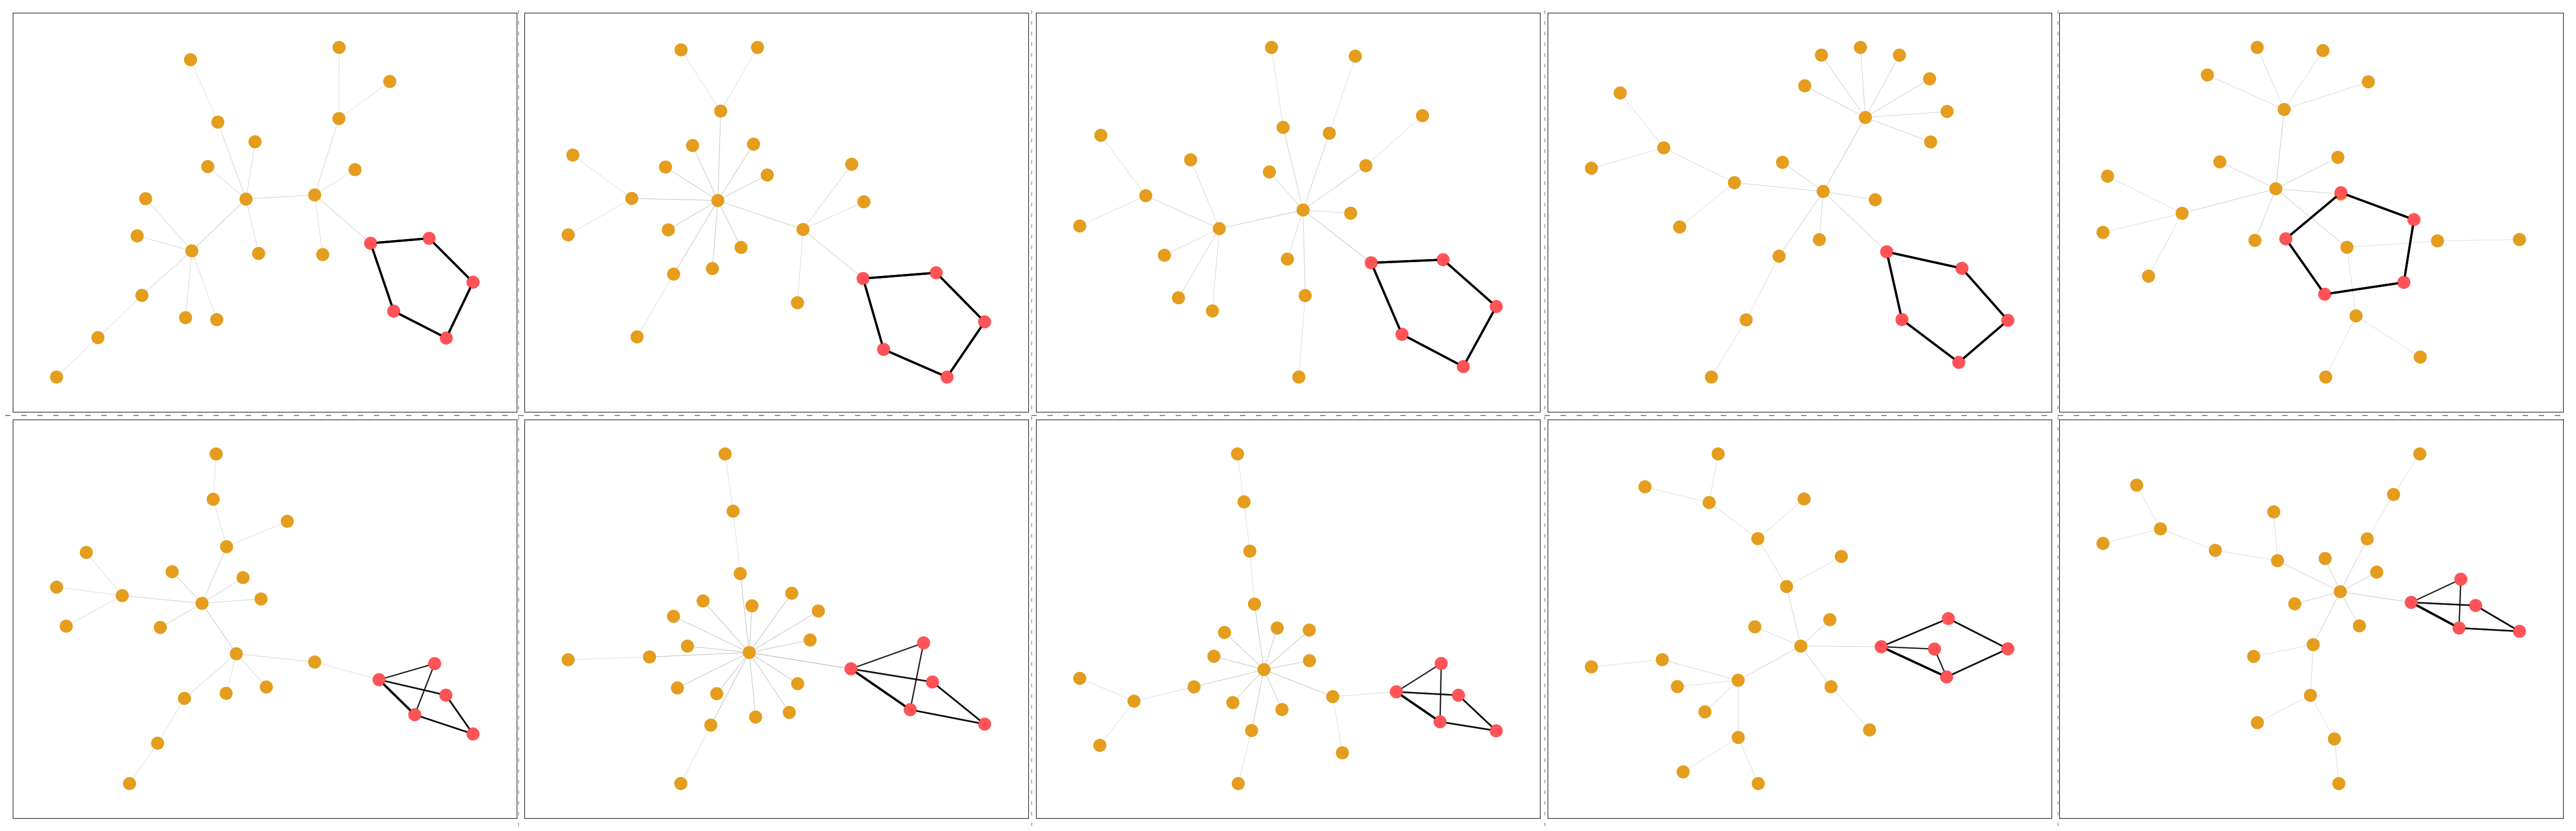

In [9]:

visualize_results(baseline, all_viz_set, test_set, num_viz_samples, dataset_name, None, method_name)
#gsat, all_viz_set, test_set, num_viz_samples, dataset_name, optimizer, method_name